In [26]:
#import bicing data file

import json

with open('data_mon12_5am_18hrs.json') as json_data:
    data = json.load(json_data)

    

    

    
    


In [27]:
print len(data[0]['stations'])

465


In [28]:
# add labels to data 

empty_stations = []
almost_empty_stations = []
almost_full_stations = []
full_stations = []



for j in range(0,len(data)):
    for i in range(0, len(data[0]['stations'])):
        id2 = i
        data[j]['stations'][i].update({'id2':id2})   #add id2 so nodes are labelled in same way as edges
        #calc proportion of bikes in station, and add "ratio" to dict
        if (float((data[j]['stations'][i]['slots']))+float((data[j]['stations'][i]['bikes']))) == 0:
            r = "CLS"
        else: 
            r = float((data[j]['stations'][i]['bikes']))/(float((data[j]['stations'][i]['slots']))+float((data[j]['stations'][i]['bikes'])))
        data[j]['stations'][i].update({'ratio':r})
        #create groupings of stations by proportion full
        if data[j]['stations'][i]['ratio'] < 0.15:
            empty_stations.append(int(data[j]['stations'][i]['id2']))
            data[j]['stations'][i].update({'ratio_label':'empty'})
        if data[j]['stations'][i]['ratio'] >= 0.15 and data[j]['stations'][i]['ratio'] < 0.50:  
            almost_empty_stations.append(int(data[j]['stations'][i]['id2']))
            data[j]['stations'][i].update({'ratio_label':'almost_empty'})
        if data[j]['stations'][i]['ratio'] >= 0.50 and data[j]['stations'][i]['ratio'] < 0.85:
            almost_full_stations.append(int(data[j]['stations'][i]['id2']))
            data[j]['stations'][i].update({'ratio_label':'almost_full'})
        if data[j]['stations'][i]['ratio'] >= 0.85:
            full_stations.append(int(data[j]['stations'][i]['id2']))
            data[j]['stations'][i].update({'ratio_label':'full'}) 



In [29]:
#thinking about distance and weights...
#finding distance between two coordinate points (lat&lon)

import math
import numpy as np

d = len(data[0]['stations'])

#function to find distance between 2 coordinate points
def distance(origin, destination):
    lat1, lon1 = origin
    lat2, lon2 = destination
    radius = 6371 # km

    dlat = math.radians(lat2-lat1)
    dlon = math.radians(lon2-lon1)
    a = math.sin(dlat/2) * math.sin(dlat/2) + math.cos(math.radians(lat1)) \
        * math.cos(math.radians(lat2)) * math.sin(dlon/2) * math.sin(dlon/2)
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1-a))
    dist = radius * c

    return dist


#create symmetric matrix of distances between 2 nodes

A = np.zeros((d,d))

for i in range(0, d):
    for j in range(i+1, d):
        #print(res['stations'][i]['id']), (res['stations'][j]['id'])
        lat1 = float((data[0]['stations'][i]['latitude']))
        #print lat1
        long1 = float((data[0]['stations'][i]['longitude']))
        #print long1
        lat2 = float((data[0]['stations'][j]['latitude']))
        #print lat2
        long2 = float((data[0]['stations'][j]['longitude']))
        #print long2
        dist = (distance((lat1, long1), (lat2, long2)) )
        #print dist
        A[i, j] = dist
        A[j, i] = dist
        
print A

[[ 0.          0.36660614  0.4816518  ...,  1.54524915  3.45165     0.87121146]
 [ 0.36660614  0.          0.39637078 ...,  1.18552311  3.08680231
   1.0509322 ]
 [ 0.4816518   0.39637078  0.         ...,  1.39741765  3.22981512
   1.33916288]
 ..., 
 [ 1.54524915  1.18552311  1.39741765 ...,  0.          1.91467454
   1.89592722]
 [ 3.45165     3.08680231  3.22981512 ...,  1.91467454  0.          3.7584962 ]
 [ 0.87121146  1.0509322   1.33916288 ...,  1.89592722  3.7584962   0.        ]]


In [30]:
from copy import copy, deepcopy
import numpy as np



#gaussian function
def gaussian_weights(x, mu, sig):
    return np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.)))

print "Gaussian weights:"
for x in range(13):
    print x, gaussian_weights(x, 0, 4)

#print A[A != 0].min()
#print A[A != 0].max()
A_copy = copy(A)

#Replace elements in distances-matrix with gaussian weights
for i in range(d):
    for j in range(d):
        A_copy[i][j] = gaussian_weights(A_copy[i][j], 0, 4)
        


Gaussian weights:
0 1.0
1 0.969233234476
2 0.882496902585
3 0.754839601989
4 0.606530659713
5 0.457833361772
6 0.324652467358
7 0.21626516683
8 0.135335283237
9 0.0795595087182
10 0.0439369336234
11 0.0227941808836
12 0.0111089965382


In [31]:
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib import dates
import datetime
% matplotlib inline


def bicing_network(dataset):
    n_stations = len(dataset[0]['stations'])

    temporal_networks = []
    temporal_degrees = []
    temporal_timestamp = []

    for t in range(0,len(dataset)):
        G_bicing = nx.Graph()

        for x in range (0, n_stations):
            G_bicing.add_node(x)
            
        for x in range (0, n_stations):
            for y in range (x, n_stations):
                
                if dataset[t]['stations'][x]['ratio_label'] == 'empty' and dataset[t]['stations'][y]['ratio_label'] == 'full' and (x != y): 
                    w = 1 - A_copy[x,y]
                    
                    G_bicing.add_edge(x, y, weight = w)
                if dataset[t]['stations'][y]['ratio_label'] == 'empty' and dataset[t]['stations'][x]['ratio_label'] == 'full' and (x != y):
                    w = 1 - A_copy[x,y]
                    G_bicing.add_edge(x, y, weight = w)
        
        
        temporal_networks.append(G_bicing)
        temporal_degrees.append(np.average(G_bicing.degree().values()))
        temporal_timestamp.append(dataset[t]['updateTime'])
        
        #print temporal_degrees[t]
    
    return temporal_networks, temporal_degrees, temporal_timestamp

bicing_results = bicing_network(data)

temporal_timestamp_regular = []
for i in range(0,len(bicing_results[2])):
    temporal_timestamp_regular.append((datetime.datetime.fromtimestamp(int(bicing_results[2][i])
    ).strftime('%H:%M')))
    temporal_timestamp_regular[i] = int(temporal_timestamp_regular[i].replace(':',''))

    


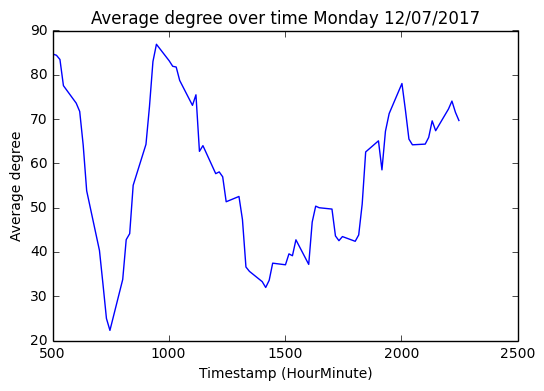

In [42]:
#plot the data 

plt.plot(temporal_timestamp_regular,bicing_results[1])
plt.xlabel('Timestamp (HourMinute)')
plt.ylabel('Average degree')
#plt.xticks(np.arange(min(temporal_timestamp_regular), max(temporal_timestamp_regular), 200))
plt.title('Average degree over time Monday 12/07/2017')
plt.show()

[{u'status': u'OPN', 'ratio': 1.0, u'type': u'BIKE', u'altitude': u'21', 'id2': 0, 'ratio_label': 'full', u'longitude': u'2.180042', u'bikes': u'18', u'streetNumber': u'760', u'latitude': u'41.397952', u'slots': u'0', u'nearbyStations': u'24, 369, 387, 426', u'id': u'1', u'streetName': u'Gran Via Corts Catalanes'}, {u'status': u'OPN', 'ratio': 0.8695652173913043, u'type': u'BIKE', u'altitude': u'21', 'id2': 1, 'ratio_label': 'full', u'longitude': u'2.17706', u'bikes': u'20', u'streetNumber': u'126', u'latitude': u'41.39553', u'slots': u'3', u'nearbyStations': u'360, 368, 387, 414', u'id': u'2', u'streetName': u'Roger de Flor/ Gran V\xeda'}, {u'status': u'OPN', 'ratio': 0.8333333333333334, u'type': u'BIKE', u'altitude': u'21', 'id2': 2, 'ratio_label': 'almost_full', u'longitude': u'2.181137', u'bikes': u'20', u'streetNumber': u'44', u'latitude': u'41.393699', u'slots': u'4', u'nearbyStations': u'4, 6, 119, 419', u'id': u'3', u'streetName': u'Ali Bei'}, {u'status': u'OPN', 'ratio': 0.285

In [124]:
from collections import defaultdict

#function to return average ratio of a station in a given day

def bicing_similarity(dataset):
    n_stations = len(dataset[0]['stations'])
    
    daily_ratio_mean = []
    daily_empty = []
    daily_full = []
    daily_almost_full = []
    daily_almost_empty = []
    ratio_dictionary = dict()
    
    for x in range(0,n_stations):
        
        for t in range(0,len(dataset)):
            ratio = data[t]['stations'][x]['ratio']
            if data[t]['stations'][x]['id2'] in ratio_dictionary:
                ratio_dictionary[data[t]['stations'][x]['id2']].append(ratio)
            else:
                ratio_dictionary[data[t]['stations'][x]['id2']] = [ratio]
            #print ratio_dictionary
            
    for y in range(0,n_stations):
        for c in range (0, len(ratio_dictionary[y])):
            if ratio_dictionary[y][c] == 'CLS':
                ratio_dictionary[y][c] = 0.0

        daily_ratio_mean.append(np.mean(ratio_dictionary[y]))
        
    for m in range(0,len(daily_ratio_mean)):
        if daily_ratio_mean[m] < 0.15:
            daily_empty.append(m)
        elif daily_ratio_mean[m] <= 0.5:
            daily_almost_empty.append(m)
        elif daily_ratio_mean[m] <= 0.85:
            daily_almost_full.append(m)
        else:
            daily_full.append(m)
            
    return daily_empty, daily_almost_empty, daily_almost_full, daily_full

daily_sim = bicing_similarity(data)

daily_e = daily_sim[0]
daily_ae = daily_sim[1]
daily_af = daily_sim[2]
daily_f = daily_sim[3]

# print daily_e
# print daily_ae
# print daily_af
# print daily_f

[58, 86, 91, 92, 94, 97, 98, 192, 199, 202, 205, 209, 211, 212, 213, 218, 219, 238, 247, 262, 265, 266, 289, 290, 291, 298, 299, 300, 304, 305, 315, 319, 320, 362, 411, 458]
[2, 3, 5, 12, 14, 17, 18, 19, 20, 21, 23, 24, 26, 27, 28, 33, 36, 37, 38, 39, 43, 45, 46, 47, 51, 57, 59, 60, 61, 62, 63, 64, 65, 66, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 84, 85, 87, 88, 89, 90, 93, 95, 96, 99, 102, 103, 104, 105, 106, 107, 108, 113, 117, 118, 119, 120, 122, 123, 124, 127, 128, 134, 136, 137, 139, 141, 147, 148, 149, 153, 157, 158, 161, 163, 166, 168, 169, 170, 171, 172, 174, 175, 176, 177, 178, 179, 182, 183, 185, 186, 187, 188, 189, 190, 191, 193, 194, 195, 196, 197, 198, 200, 201, 203, 204, 206, 208, 210, 214, 216, 217, 220, 221, 222, 223, 224, 225, 226, 227, 228, 231, 232, 233, 234, 235, 236, 237, 239, 240, 241, 243, 244, 245, 246, 248, 249, 250, 251, 252, 258, 260, 261, 269, 270, 271, 272, 273, 274, 275, 276, 277, 278, 279, 280, 283, 284, 286, 287, 288, 292, 293, 294, 295, 296, 297,

In [125]:
# average split by time of day

def similarity_day_split(dataset):
    n_stations = len(dataset[0]['stations'])
    
    morning_mean = []
    midday_mean = []
    eve_mean = []
    
    morning_empty = []
    morning_full = []
    morning_almost_full = []
    morning_almost_empty = []
    
    midday_empty = []
    midday_full = []
    midday_almost_full = []
    midday_almost_empty = []
    
    eve_empty = []
    eve_full = []
    eve_almost_full = []
    eve_almost_empty = []
    
    mor_ratio_dictionary = dict()
    mid_ratio_dictionary = dict()
    eve_ratio_dictionary = dict()
    
    timestamp_u = []
    for timestamp in range(0,len(dataset)):
        timestamp_u.append(dataset[timestamp]['updateTime'])
        
    
    timestamp = []                
    for i in range(0,len(dataset)):
        timestamp.append((datetime.datetime.fromtimestamp(int(timestamp_u[i])).strftime('%H:%M')))
        timestamp[i] = int(timestamp[i].replace(':',''))
    
    for x in range(0,n_stations):
        
        for t in range(0,len(dataset)):
            
            if timestamp[t] < 1100: 
                ratio = data[t]['stations'][x]['ratio']
                if data[t]['stations'][x]['id2'] in mor_ratio_dictionary:
                    mor_ratio_dictionary[data[t]['stations'][x]['id2']].append(ratio)
                else:
                    mor_ratio_dictionary[data[t]['stations'][x]['id2']] = [ratio]  
            elif timestamp[t] < 1700: 
                ratio = data[t]['stations'][x]['ratio']
                if data[t]['stations'][x]['id2'] in mid_ratio_dictionary:
                    mid_ratio_dictionary[data[t]['stations'][x]['id2']].append(ratio)
                else:
                    mid_ratio_dictionary[data[t]['stations'][x]['id2']] = [ratio]    
            else:
                ratio = data[t]['stations'][x]['ratio']
                if data[t]['stations'][x]['id2'] in eve_ratio_dictionary:
                    eve_ratio_dictionary[data[t]['stations'][x]['id2']].append(ratio)
                else:
                    eve_ratio_dictionary[data[t]['stations'][x]['id2']] = [ratio]                    
            
    for y in range(0,n_stations):
        for c in range (0, len(mor_ratio_dictionary[y])):
            if mor_ratio_dictionary[y][c] == 'CLS':
                mor_ratio_dictionary[y][c] = 0.0
        for c in range (0, len(mid_ratio_dictionary[y])):
            if mid_ratio_dictionary[y][c] == 'CLS':
                mid_ratio_dictionary[y][c] = 0.0
        for c in range (0, len(eve_ratio_dictionary[y])):
            if eve_ratio_dictionary[y][c] == 'CLS':
                eve_ratio_dictionary[y][c] = 0.0
        
        morning_mean.append(np.mean(mor_ratio_dictionary[y]))
        midday_mean.append(np.mean(mid_ratio_dictionary[y]))
        eve_mean.append(np.mean(eve_ratio_dictionary[y]))
                
    for m in range(0,len(morning_mean)):
            if morning_mean[m] < 0.15:
                morning_empty.append(m)
            elif morning_mean[m] <= 0.5:
                morning_almost_empty.append(m)
            elif morning_mean[m] <= 0.85:
                morning_almost_full.append(m)
            else:
                morning_full.append(m)
                
    for m in range(0,len(midday_mean)):
            if midday_mean[m] < 0.15:
                midday_empty.append(m)
            elif midday_mean[m] <= 0.5:
                midday_almost_empty.append(m)
            elif midday_mean[m] <= 0.85:
                midday_almost_full.append(m)
            else:
                midday_full.append(m)
    for m in range(0,len(eve_mean)):
            if eve_mean[m] < 0.15:
                eve_empty.append(m)
            elif eve_mean[m] <= 0.5:
                eve_almost_empty.append(m)
            elif eve_mean[m] <= 0.85:
                eve_almost_full.append(m)
            else:
                eve_full.append(m)
                
    return morning_empty, morning_almost_empty, morning_almost_full, morning_full, midday_empty, midday_almost_empty, midday_almost_full, midday_full, eve_empty, eve_almost_empty, eve_almost_full, eve_full

daily_sim_split = similarity_day_split(data)

morning_e = daily_sim_split[0]
morning_ae = daily_sim_split[1]
morning_af = daily_sim_split[2]
morning_f = daily_sim_split[3]

midday_e = daily_sim_split[4]
midday_ae = daily_sim_split[5]
midday_af = daily_sim_split[6]
midday_f = daily_sim_split[7]

eve_e = daily_sim_split[8]
eve_ae = daily_sim_split[9]
eve_af = daily_sim_split[10]
eve_f = daily_sim_split[11]

print 'morning', morning_e, morning_ae, morning_af, morning_f
print 'midday', midday_e, midday_ae, midday_af, midday_f
print 'evening', eve_e, eve_ae, eve_af, eve_f

morning [9, 24, 32, 33, 36, 79, 91, 92, 93, 98, 168, 169, 170, 171, 176, 187, 188, 199, 202, 205, 211, 212, 213, 231, 233, 234, 247, 252, 260, 265, 266, 271, 280, 284, 289, 291, 292, 295, 296, 297, 298, 299, 300, 305, 311, 319, 320, 362, 379, 385, 396, 411, 412, 414, 430, 458] [2, 3, 5, 8, 10, 13, 14, 15, 16, 17, 19, 20, 21, 22, 23, 25, 26, 27, 28, 29, 31, 37, 38, 39, 40, 44, 45, 46, 48, 50, 53, 54, 56, 57, 58, 59, 60, 62, 65, 66, 69, 70, 71, 72, 73, 74, 76, 78, 80, 81, 82, 84, 85, 86, 87, 88, 89, 90, 94, 95, 96, 97, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 111, 112, 114, 116, 117, 118, 119, 120, 121, 123, 127, 137, 139, 141, 145, 147, 149, 150, 151, 158, 160, 161, 162, 163, 165, 166, 167, 172, 174, 175, 177, 178, 179, 180, 181, 182, 183, 185, 186, 189, 190, 191, 192, 193, 194, 197, 198, 200, 201, 203, 204, 206, 207, 209, 210, 215, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 230, 232, 235, 236, 238, 239, 240, 241, 242, 243, 246, 248, 250, 258, 261, 262, 270, 272

In [81]:
data[0]['updateTime']

1497236528